# Introduction

In this Notebook, we will load the fine-tuned model and test with the test data.

In [1]:
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U transformers=="4.40.0"
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Prepare the data and the model

In [4]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


2025-10-08 15:11:10.282685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759936270.475049      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759936270.530834      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
filename = "/kaggle/input/financial-sentiment-analysis/data.csv"

df = pd.read_csv(filename, 
                 encoding="utf-8", encoding_errors="replace")

In [6]:
df.columns = ["text", "sentiment"]

We perform the same train/eval/split as we did for fine-tuning.

In [7]:
X_train = list()
X_test = list()
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment==sentiment], 
                                    train_size=300,
                                    test_size=300, 
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

In [8]:
def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = """.strip()

In [9]:
y_true = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

In [10]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)
    
    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Class labels
    class_labels = ['negative', 'neutral', 'positive']

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) 
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label `{class_labels[label]}`: {accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred, target_names=class_labels)
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

    # Create a heatmap
    plt.figure(figsize=(6, 5))
   
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    
    # Add labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


In [12]:
model_name = "/kaggle/input/gemma2-sentiment-analysis/transformers/gemma2_2b_en_sentiment_analysis/4"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

max_seq_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)
tokenizer.pad_token_id = tokenizer.eos_token_id

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
def predict(test, predictor_model, tokenizer):
    y_pred = []
    
    pipe = pipeline(task="text-generation", 
            model=predictor_model, 
            tokenizer=tokenizer, 
            max_new_tokens = 1, 
            temperature = 0.1,
    )
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1]
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

# Predict using the fine-tuned model

In [14]:
y_pred = predict(X_test, model, tokenizer)

Device set to use cuda:0
100%|██████████| 900/900 [01:53<00:00,  7.94it/s]


# Evaluate using the fine-tuned model

Accuracy: 0.841
Accuracy for label `negative`: 0.907
Accuracy for label `neutral`: 0.767
Accuracy for label `positive`: 0.850

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.91      0.87       300
     neutral       0.80      0.77      0.78       300
    positive       0.90      0.85      0.87       300

    accuracy                           0.84       900
   macro avg       0.84      0.84      0.84       900
weighted avg       0.84      0.84      0.84       900


Confusion Matrix:
[[272  20   8]
 [ 49 230  21]
 [  6  39 255]]


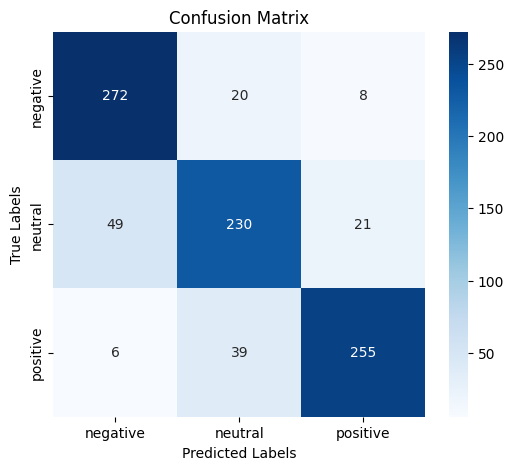

In [15]:
evaluate(y_true, y_pred)